Suggestion: Run this on a computer with a GPU and a large amount of RAM
On my laptop (no GPU) this notebook was consuming ~14GB of ram and 6 out of 8 CPU cores
I like floydhub for their ease of use, however they are more expensive than other providers

In [ ]:
#!pip install gensim

In [1]:
import numpy as np
import json

from gensim.models import KeyedVectors

from keras.models import Model, load_model, model_from_json
from keras.layers import (Input,Embedding,LSTM,Dense,Dropout)
from keras.optimizers import Adam
from keras.datasets import imdb
from keras.utils import to_categorical
from keras.preprocessing import sequence
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load iMBd dataset
# add special padding, start, and out of vocab tokens to vocabulary
pad_value = 0
start_value = 1
oov_value = 2
shift = 3
skip_top = 0 # trim the most frequent words
num_words = None # keep only the most frequent words
max_review_length = 128 # truncate reviews that are too long, keeps training time down from 8 hours -> 1 hour
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=num_words,
                                                      skip_top=skip_top,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=start_value,
                                                      oov_char=oov_value,
                                                      index_from=shift)
if max_review_length:
    x_train = np.array([review[0:max_review_length] for review in x_train])
    x_test = np.array([review[0:max_review_length] for review in x_test])

token_to_int = {tok:i+shift for tok,i in imdb.get_word_index().items()}
token_to_int['-PAD-'] = pad_value
token_to_int['-START-'] = start_value
token_to_int['-OOV-'] = oov_value

int_to_token = {i:tok for tok,i in token_to_int.items()}

vocab_size = len(token_to_int)
train_size = len(x_train)
test_size = len(x_test)

print('Vocab Size:',vocab_size)
print('Train Size:',train_size)
print('Test Size:',test_size)

# Load the Google News embeddings                                                                        
model = KeyedVectors.load_word2vec_format('/embeddings/GoogleNews-vectors-negative300.bin',binary=True)   
embedding_weights = model.wv.vectors                                                                           
                                                                                                         
# These embeddings need to be tied to the iMDb tokens                                                    
# Step 1: Build a Google News token -> vector index look-up table                                        
# Step 2: Build a vector index -> iMDb integer encoding look-up table                                    
# Step 3: Build an iMDb integer encoding -> vector look-up table                                         
# Step 4: Reconstruct the embedding weight matrix using the iMDb integer encoding                        
                                                                                                         
token_to_vecidx = {tok:i for i,tok in enumerate(model.index2word)} # Step 1                              
vecidx_to_int = {idx:token_to_int[tok] for tok,idx in token_to_vecidx.items() \
                 if token_to_int.get(tok)} # Step 2                                                                   
int_to_vec = {i:embedding_weights[idx] for idx,i in vecidx_to_int.items()} # Step 3                      
                                                                                                         
weights = np.zeros((max(list(int_to_token.keys())),embedding_weights.shape[1]))                          
for i,vec in int_to_vec.items():                                                                         
    weights[i] = vec

Vocab Size: 88587
Train Size: 25000
Test Size: 25000


/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:39: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [3]:
# since we are one hot encoding each review will have a size of (review_length,vocab_size)
# which is quite large and may eat up too much memory.
# To fix this I will define a generator function that will read the integer encoded reviews
# and feed a mini batch of reviews to the model for training
def data_generator(X,y,batch_size=8,shuffle=True):
    indices = np.arange(len(X))
    last_idx = 0
    while True:
        if shuffle: # shuffle for training
            idxs = np.random.choice(indices,batch_size)
        else: # dont shuffle for testing
            idxs = indices[last_idx:last_idx+batch_size]
        X_mini = X[idxs]
        maxlen = max(list(map(len,X_mini)))
        # each sequence in the batch need to have the same length
        # even though the model can accept sequences of different lengths
        X_mini_pad = sequence.pad_sequences(X_mini,maxlen=maxlen,value=pad_value)
        y_mini = y[idxs]
        
        yield X_mini_pad,y_mini
        
        last_idx += batch_size
        if last_idx >= len(X):
            last_idx = 0

# define a function to convert the integer encoded sequence to text
def decode_review(encoded_review):
    return [int_to_token.get(i,'-OOV') for i in encoded_review]

# Preview a random movie review
np.random.seed(7) # comment out this line to see other reviews
encoded_review = np.random.choice(x_train)
review_text = ' '.join(decode_review(encoded_review))
print(encoded_review)
print('-'*100)
print(review_text)

[1, 4002, 24, 6, 78, 96, 8, 380, 12, 13, 197, 14, 16, 204, 21, 95, 13, 1957, 12, 16, 6, 6574, 7, 4, 5731, 1034, 7, 711, 1991, 13, 115, 219, 711, 1991, 366, 13, 16, 1119, 13, 219, 14, 22, 54, 13, 16, 790, 4, 598, 8526, 7509, 228, 80, 79, 1571, 11, 129, 419, 24, 8, 760, 4, 598, 756, 613, 34, 4, 44889, 14, 9, 4, 249, 1664, 302, 207, 126, 110, 33, 4, 172, 58, 14, 22, 1287, 6, 3942, 9997, 7, 503, 102, 906, 4414, 193, 6, 46425, 5, 140, 8, 1445, 276, 4, 5887, 11, 129, 5215, 5, 25, 28, 5887, 671, 13, 377, 319, 14, 22, 23, 20, 70794, 11645, 34, 3584, 50, 9, 31, 136, 121, 12, 16, 40]
----------------------------------------------------------------------------------------------------
-START- lol not a bad way to start it i thought this was original but then i discovered it was a clone of the 1976 remake of king kong i never saw king kong until i was 15 i saw this film when i was 9 the film's funky disco music will get stuck in your head not to mention the film's theme song by the yetians this is 

In [4]:
# define a model to predict the sentiment of a review
# based on the one-hot-encoding input
# define an additional model to view the intermediate embedding layer of the lstm
# it might be interesting to see how the lstm is emebedding the different reviews
lstm_size = 256

def learned_embedding_model():
    review_input = Input(shape=(None,))
    embedding_layer = Embedding(vocab_size,300,mask_zero=True)
    review_embedding = embedding_layer(review_input)
    lstm_layer = LSTM(lstm_size)
    lstm_output = lstm_layer(review_embedding)
    densor = Dense(1,activation='sigmoid')
    output = densor(lstm_output)
    
    model = Model(review_input,output)
    lstm_model = Model(review_input,lstm_output)
    return model, lstm_model

def pretrained_embedding_model():
    review_input = Input(shape=(None,))
    embedding_layer = Embedding(weights.shape[0],
                                weights.shape[1],
                                weights=[weights],
                                trainable=False,
                                mask_zero=True)
    review_embedding = embedding_layer(review_input)
    lstm_layer = LSTM(lstm_size)
    lstm_output = lstm_layer(review_embedding)
    densor = Dense(1,activation='sigmoid')
    output = densor(lstm_output)
    
    model = Model(review_input,output)
    lstm_model = Model(review_input,lstm_output) # allows you to inspect the hidden LSTM layer
    return model, lstm_model

In [6]:
# running this cell may crash your notebook
# training the embedding model is very computationaly expensive

# my laptop gpu only has 2GB of memory and fails to train this model
# this model can be trained on my cpu, however each epoch takes ~2 hours
# if your gpu runs out of memory, uncomment the following "with" block and indent appropriately.

batch_size = 128
train_generator = data_generator(x_train,y_train,batch_size=batch_size,shuffle=True)
test_generator = data_generator(x_test,y_test,batch_size=batch_size,shuffle=False)
train_steps = len(x_train)//batch_size+1
test_steps = len(x_test)//batch_size+1
epochs = 2

#with tf.device('/cpu:0'):
embedding_model,lstm_embedding = learned_embedding_model()
embedding_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
print(embedding_model.summary())
    

embedding_model.fit_generator(train_generator,
                        validation_data=test_generator,
                        steps_per_epoch=train_steps,
                        epochs=epochs,
                        validation_steps=test_steps)

# serialize model to JSON
model_json = embedding_model.to_json()
with open("models/learned_embedding_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
embedding_model.save_weights("models/learned_embedding_model.h5")
print("Saved model to disk")

# serialize model to JSON
model_json = lstm_embedding.to_json()
with open("models/learned_lstm_embedding.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstm_embedding.save_weights("models/learned_lstm_embedding.h5")
print("Saved model to disk")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 300)         26576100  
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 27,146,725
Trainable params: 27,146,725
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
196/196 [==============================] - 167s - loss: 0.4464 - acc: 0.7891 - val_loss: 0.4615 - val_acc: 0.8087
Epoch 2/2
196/196 [==============================] - 165s - loss: 0.2079 - acc: 0.9247 - val_loss: 0.5009 - val_acc: 0.8103
Saved mod

Note: The vast majority of the models parameters are for the word embeddings, 26.5M. This makes the model very flexible and overfit very easily, which I found to become drastic after 2 epochs.

In [7]:
train_generator = data_generator(np.array(x_train),y_train,batch_size=batch_size,shuffle=True)
test_generator = data_generator(np.array(x_test),y_test,batch_size=batch_size,shuffle=False)
train_steps = len(x_train)//batch_size+1
test_steps = len(x_test)//batch_size+1
epochs = 6
#with tf.device('/cpu:0'):
pre_model,pre_lstm_embedding = pretrained_embedding_model()
pre_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
print(pre_model.summary())
    

pre_model.fit_generator(train_generator,
                        validation_data=test_generator,
                        steps_per_epoch=train_steps,
                        epochs=epochs,
                        validation_steps=test_steps)

# serialize model to JSON
model_json = pre_model.to_json()
with open("models/pretrained_embedding_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
pre_model.save_weights("models/pretrained_embedding_model.h5")
print("Saved model to disk")

# serialize model to JSON
model_json = pre_lstm_embedding.to_json()
with open("models/pretrained_lstm_embedding.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
pre_lstm_embedding.save_weights("models/pretrained_lstm_embedding.h5")
print("Saved model to disk")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 300)         26576100  
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 27,146,725
Trainable params: 570,625
Non-trainable params: 26,576,100
_________________________________________________________________
None
Epoch 1/6
196/196 [==============================] - 157s - loss: 0.5385 - acc: 0.7296 - val_loss: 0.4867 - val_acc: 0.7937
Epoch 2/6
196/196 [==============================] - 157s - loss: 0.4618 - acc: 0.7952 - val_loss: 0.4424 - val_acc: 0.7995
Epo

With the training complete I am interested to see the output of the intermediate lstm layers in both models.
These lstm layers are responsible for converting the word embeddings (learned or pretrained) into a set of features that can be used for sentiment classification.

In [8]:
#with tf.device('/cpu:0'):
with open('models/learned_lstm_embedding.json') as json_model:
    learned_lstm_embedding = model_from_json(json_model.read())
    learned_lstm_embedding.load_weights('models/learned_lstm_embedding.h5')

with open('models/pretrained_lstm_embedding.json') as json_model:
    pretrained_lstm_embedding = model_from_json(json_model.read())
    pretrained_lstm_embedding.load_weights('models/pretrained_lstm_embedding.h5')

In [9]:
mini_batch_idxs = np.random.choice(np.arange(len(x_test)),1000,replace=False)
mini_batch = x_test[mini_batch_idxs]
sequences = sequence.pad_sequences(mini_batch,maxlen=300,value=pad_value)

lstm_vecs = learned_lstm_embedding.predict(sequences)
pre_lstm_vecs = pretrained_lstm_embedding.predict(sequences)

In [10]:
kmeans = KMeans(10)
clusters = kmeans.fit_predict(lstm_vecs)
# no need to declare a new kmeans instance, will just re-fit
pre_clusters = kmeans.fit_predict(pre_lstm_vecs)

tsne = TSNE(metric='euclidean',n_iter=500)
proj = tsne.fit_transform(lstm_vecs)
pre_proj = tsne.fit_transform(pre_lstm_vecs)

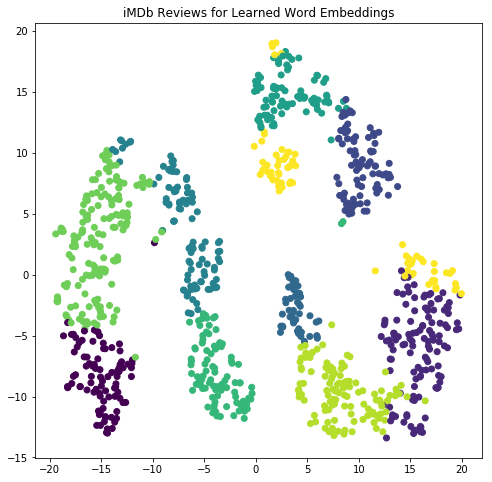

In [12]:
plt.figure(figsize=(8,8))
plt.title('iMDb Reviews for Learned Word Embeddings')
plt.scatter(proj[:,0],proj[:,1],c=clusters,cmap=plt.cm.get_cmap('viridis'))
plt.savefig('images/imdb_review_embeddings.png')

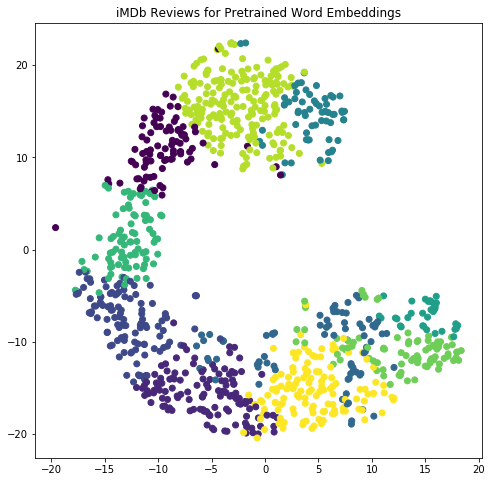

In [13]:
plt.figure(figsize=(8,8))
plt.title('iMDb Reviews for Pretrained Word Embeddings')
plt.scatter(pre_proj[:,0],pre_proj[:,1],c=pre_clusters,cmap=plt.cm.get_cmap('viridis'))
plt.savefig('images/imdb_review_embeddings_pretrained.png')

In [14]:
print('Cluster    True Sentiment    Predicted Sentiment    Population Size')
space = '    '
for cluster_label in range(max(clusters)+1):
    cluster_sequences = sequences[clusters==cluster_label]
    cluster_sentiment = y_test[mini_batch_idxs][clusters==cluster_label]
    predict_sentiment = embedding_model.predict(cluster_sequences)
    cluster_reviews = [' '.join([int_to_token[i] for i in encoded if i not in {start_value,pad_value}]) for encoded in cluster_sequences]
    mu = np.mean(cluster_sentiment)
    s = np.std(cluster_sentiment)
    p_mu = np.mean(predict_sentiment)
    print(cluster_label,space*4,'%0.2f'%(100*mu),space*4,'%0.2f'%(100*p_mu),space*4,len(cluster_sentiment))
    #print(cluster_label,':','True Sentiment: %0.2f   Predicted Sentiment: %0.2f'%(100*mu,100*p_mu),'   Cluster Size:',len(cluster_sentiment))

Cluster    True Sentiment    Predicted Sentiment    Population Size
0                  2.11                  0.93                  95
1                  85.37                  96.89                  123
2                  48.86                  54.52                  88
3                  94.23                  99.55                  52
4                  22.12                  8.09                  104
5                  55.68                  83.73                  88
6                  40.62                  23.77                  96
7                  8.02                  2.82                  162
8                  91.53                  98.77                  118
9                  70.27                  93.30                  74


In [15]:
print('Cluster    True Sentiment    Predicted Sentiment    Population Size')
space = '    '
for cluster_label in range(max(pre_clusters)+1):
    cluster_sequences = sequences[pre_clusters==cluster_label]
    cluster_sentiment = y_test[mini_batch_idxs][pre_clusters==cluster_label]
    predict_sentiment = pre_model.predict(cluster_sequences)
    cluster_reviews = [' '.join([int_to_token[i] for i in encoded if i not in {start_value,pad_value}]) for encoded in cluster_sequences]
    mu = np.mean(cluster_sentiment)
    s = np.std(cluster_sentiment)
    p_mu = np.mean(predict_sentiment)
    print(cluster_label,space*4,'%0.2f'%(100*mu),space*4,'%0.2f'%(100*p_mu),space*4,len(cluster_sentiment))
    #print(cluster_label,':','True Sentiment: %0.2f   Predicted Sentiment: %0.2f'%(100*mu,100*p_mu),'   Cluster Size:',len(cluster_sentiment))

Cluster    True Sentiment    Predicted Sentiment    Population Size
0                  20.22                  7.90                  89
1                  64.80                  83.57                  125
2                  43.75                  57.42                  112
3                  91.03                  92.10                  78
4                  0.00                  3.13                  63
5                  94.12                  98.83                  34
6                  22.99                  29.16                  87
7                  96.47                  98.46                  85
8                  3.05                  3.59                  197
9                  95.38                  95.38                  130


In [22]:
cluster_label = 4
cluster_sequences = sequences[pre_clusters==cluster_label]
for idx in np.random.choice(np.arange(len(cluster_sequences)),5):
    seq = cluster_sequences[idx]
    review = [t for t in decode_review(seq)]

['-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', 

In [21]:
seq

NameError: name 'seq' is not defined

In [ ]:
plt.figure(figsize=(8,8))
plt.title('iMDb Reviews for Pretrained Word Embeddings')
plt.scatter(pre_proj[:,0],pre_proj[:,1],c=pre_clusters,cmap=plt.cm.get_cmap('viridis'))